# CNN Dogs and Cats Classifier

## Import Libraries

In [1]:
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import os

## Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
dir_="data"
train="train"
test="test1"

## Prepare data

### Split

In [3]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("pics.csv")
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=97)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [4]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning and Validation Generator
Make modifications to pictures to increase the pool

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


#### Ejemplo

In [7]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


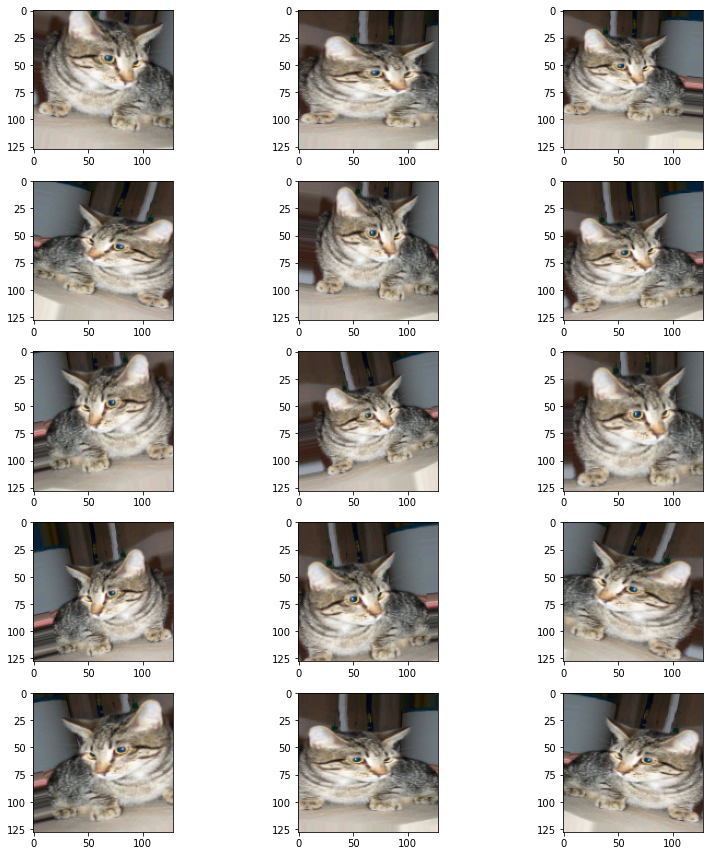

In [8]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Create model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Ejecutado capa a capa
model = Sequential()

# 3 Grupos de convoluciones:

# # Primero:
model.add(Conv2D(32,      # Las potencias de 2 están optimizadas para la fase de entrenamiento,
                          # empezamos con un número pequeño para no sobrecargar al sistema
                 (3, 3),  # Tamaño del filtro
                 activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) # Es interesante indicarlo si no son cuadradas
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # Se define una ventana y se obtiene el máximo, de manera que se reduce el tamaño de la imagen
model.add(Dropout(0.25))

# # Segundo:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# # Tercero:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# # Flatten:
model.add(Flatten())
model.add(Dense(512, activation='relu')) # Full conected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,
                activation='softmax'))  # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [11]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

### Fit model

In [14]:
epochs = 5 if FAST_RUN else 50
history = model.fit(train_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=total_validate // batch_size,
                              steps_per_epoch=total_train // batch_size,
                              callbacks=callbacks)  # Los callbacks definidos antes

Epoch 1/50
1333/1333 [==============================] - 141s 106ms/step - loss: 0.7335 - accuracy: 0.6324 - val_loss: 0.5785 - val_accuracy: 0.7197
Epoch 2/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.5578 - accuracy: 0.7184 - val_loss: 0.4982 - val_accuracy: 0.7788
Epoch 3/50
1333/1333 [==============================] - 128s 96ms/step - loss: 0.5035 - accuracy: 0.7585 - val_loss: 0.5521 - val_accuracy: 0.7552
Epoch 4/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.4676 - accuracy: 0.7848 - val_loss: 0.4864 - val_accuracy: 0.7738
Epoch 5/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.4411 - accuracy: 0.7989 - val_loss: 0.5944 - val_accuracy: 0.7616
Epoch 6/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.4231 - accuracy: 0.8101 - val_loss: 0.3800 - val_accuracy: 0.8406
Epoch 7/50
1333/1333 [==============================] - 131s 98ms/step - loss: 0.3961 - accuracy: 0.8240 - val_loss: 

1333/1333 [==============================] - 120s 90ms/step - loss: 0.3045 - accuracy: 0.8724 - val_loss: 0.3243 - val_accuracy: 0.8727
Epoch 22/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.3049 - accuracy: 0.8707 - val_loss: 0.2321 - val_accuracy: 0.9109
Epoch 23/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.3032 - accuracy: 0.8704 - val_loss: 0.2688 - val_accuracy: 0.8951
Epoch 24/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.2975 - accuracy: 0.8745 - val_loss: 0.2357 - val_accuracy: 0.9081
Epoch 25/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.2924 - accuracy: 0.8766 - val_loss: 0.3617 - val_accuracy: 0.8490
Epoch 26/50
1333/1333 [==============================] - 131s 98ms/step - loss: 0.2949 - accuracy: 0.8775 - val_loss: 0.2800 - val_accuracy: 0.8881
Epoch 27/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.2881 - accuracy: 0.8792 - val_loss: 0.4157

Epoch 42/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.2611 - accuracy: 0.8916 - val_loss: 0.1886 - val_accuracy: 0.9233
Epoch 43/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.2663 - accuracy: 0.8898 - val_loss: 0.2176 - val_accuracy: 0.9161
Epoch 44/50
1333/1333 [==============================] - 132s 99ms/step - loss: 0.2600 - accuracy: 0.8925 - val_loss: 0.2260 - val_accuracy: 0.9093
Epoch 45/50
1333/1333 [==============================] - 122s 92ms/step - loss: 0.2613 - accuracy: 0.8916 - val_loss: 0.2772 - val_accuracy: 0.8867
Epoch 46/50
1333/1333 [==============================] - 121s 91ms/step - loss: 0.2576 - accuracy: 0.8946 - val_loss: 0.2114 - val_accuracy: 0.9215
Epoch 47/50
1333/1333 [==============================] - 127s 95ms/step - loss: 0.2673 - accuracy: 0.8910 - val_loss: 0.2107 - val_accuracy: 0.9219
Epoch 48/50
1333/1333 [==============================] - 122s 92ms/step - loss: 0.2601 - accuracy: 0.8910 - val_

#### Save model and weights

In [15]:
model.save("model.h5")
model.save_weights("weights.h5")

#### Load Model

In [16]:
from keras.models import load_model
model = load_model("model.h5")


In [18]:
import numpy as np

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

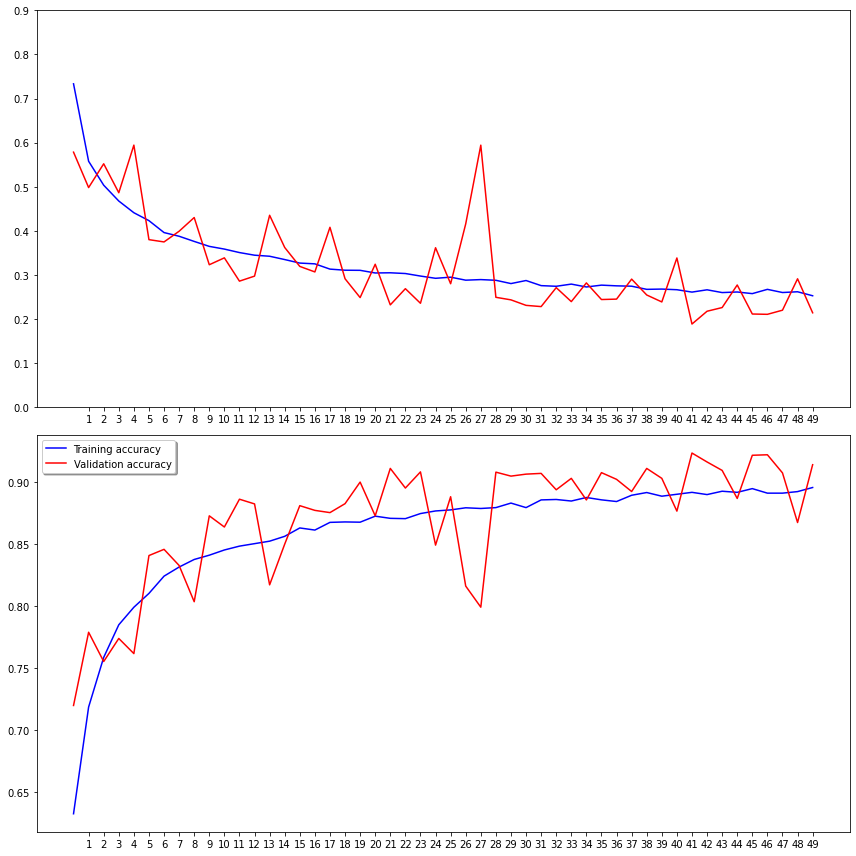

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Kaggle summision

In [ ]:
sample_file = test_df.sample().filename.values[0]

In [ ]:
sample_file

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
image = load_img(os.path.join(dir_,test,sample_file))
input_arr = img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [ ]:
test_filenames = os.listdir("data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = [item[0] for item in predict]
test_df['category_rounded'] = np.argmax(predict, axis=-1)
test_df['category_tag'] = test_df['category_rounded'].apply(lambda x: "cat" if x==0 else "dog")
test_df

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category_tag']
    img = load_img(os.path.join(dir_, test, filename), target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f"{filename} ({category})")
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# END